In [2]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pennylane.templates import RandomLayers

In [47]:
n_epochs = 30
n_layers = 1
n_train = 50 
n_test = 30

SAVE_PATH = 'quanvolution/'
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

In [48]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255 

train_images = np.array(train_images[..., tf.newaxis], requires_grad = False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad = False)


In [49]:
dev = qml.device('default.qubit', wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for i in range(4):
        qml.RY(np.pi * phi[i], wire=i)
        
    RandomLayers(rand_params, wires=list(range(4)))
    
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [50]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = ([
                image[j, k, 0],
                image[j+1, k, 0],
                image[j, k+1, 0],
                image[j+1, k+1, 0]
            ]
            )
            
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
        
    return out

In [51]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


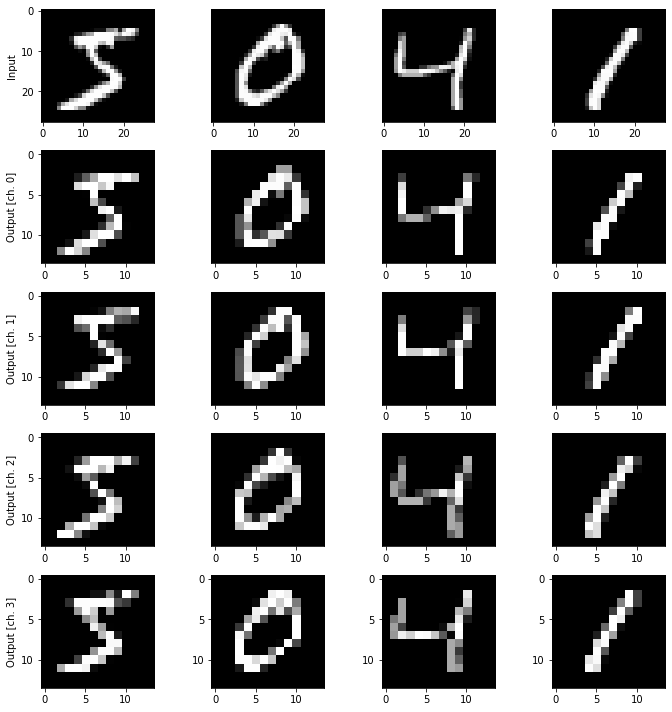

In [52]:
n_samples = 4
n_channels = 4

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [53]:
def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [54]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3770 - accuracy: 0.0600 - val_loss: 2.1724 - val_accuracy: 0.1333 - 344ms/epoch - 26ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0034 - accuracy: 0.2600 - val_loss: 2.0195 - val_accuracy: 0.3333 - 76ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7091 - accuracy: 0.6000 - val_loss: 1.8804 - val_accuracy: 0.4000 - 78ms/epoch - 6ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4693 - accuracy: 0.7600 - val_loss: 1.7505 - val_accuracy: 0.5333 - 80ms/epoch - 6ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2613 - accuracy: 0.8600 - val_loss: 1.6358 - val_accuracy: 0.6333 - 79ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0977 - accuracy: 0.8600 - val_loss: 1.5496 - val_accuracy: 0.6333 - 74ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9555 - accuracy: 0.9000 - val_loss: 1.4842 - val_accuracy: 0.6667 - 60ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8364 - accuracy: 0.9000 - val_loss: 1.4136 - val_accuracy: 0.7333 - 57ms/epoch - 4ms/step
Epoch 9/30
13/13 - 0s 

In [55]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.3920 - accuracy: 0.1000 - val_loss: 2.3593 - val_accuracy: 0.0333 - 345ms/epoch - 27ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0247 - accuracy: 0.2600 - val_loss: 2.1961 - val_accuracy: 0.1000 - 77ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7295 - accuracy: 0.5200 - val_loss: 2.0452 - val_accuracy: 0.2000 - 81ms/epoch - 6ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4919 - accuracy: 0.7400 - val_loss: 1.8979 - val_accuracy: 0.3000 - 78ms/epoch - 6ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2813 - accuracy: 0.8800 - val_loss: 1.7643 - val_accuracy: 0.5000 - 77ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1111 - accuracy: 0.9000 - val_loss: 1.6653 - val_accuracy: 0.5000 - 68ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9656 - accuracy: 0.9200 - val_loss: 1.5896 - val_accuracy: 0.5667 - 69ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8459 - accuracy: 0.9400 - val_loss: 1.5169 - val_accuracy: 0.6333 - 64ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

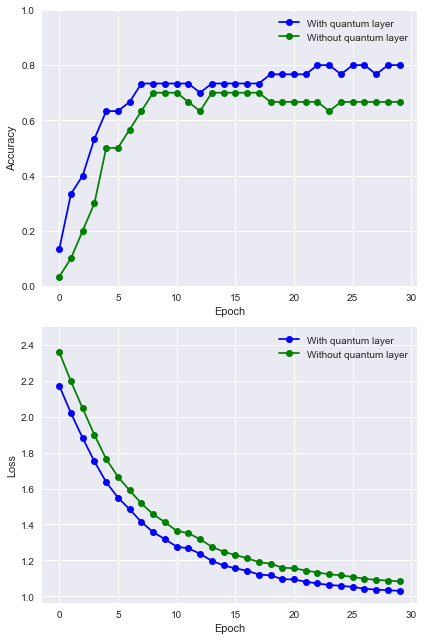

In [56]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()